# Telco Customer Churn

In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from collections import defaultdict

pd.set_option("display.max_columns",1000)

## 0. User Defined Functions

Function to return a dataframe after stripping all leading and trailing spaces. 
This fucntion expects a dataframe as an input and returns a cleaned dataframe.

In [21]:
def fn_trim_cols(df):
    clean_df = df.apply(lambda x: x.str.strip().replace('',np.nan) 
                        if x.dtype=="object"
                        else x)
    return clean_df

In [22]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df

## 1. Reading Dataset and assigning datatypes

In [42]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset = fn_trim_cols(master_dataset)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
num_rows = master_dataset.shape[0]
num_cols = master_dataset.shape[1]
print("Rows ",num_rows)
print("Cols ",num_cols)

Rows  7043
Cols  21


In [44]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [45]:
master_dataset.describe(include="all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6530,2
top,3275-RHRNE,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [46]:
categories_=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines',
             'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod','Churn']
ints_=['tenure']
floats_=['MonthlyCharges','TotalCharges']
objects_=['customerID']
master_dataset = fn_set_dtypes(master_dataset,categories_,ints_,floats_,objects_)
master_dataset.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

## 2. Data Preprocessing

### Scaling Continous variables

In [78]:
def fn_minMax_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = MinMaxScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"minMax_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("minMax_"+variable_)
    return df,scaled_num_features,scale_obj

In [86]:
def fn_SS_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = StandardScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"SS_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("SS_"+variable_)
    return df,scaled_num_features,scale_obj

In [121]:
master_dataset,scaled_mm_nums_,minMax_scale_obj = fn_minMax_scale(master_dataset,ints_+floats_)

In [122]:
master_dataset,scaled_ss_nums_,SS_scale_obj = fn_SS_scale(master_dataset,ints_+floats_)

In [89]:
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges,SS_tenure,SS_MonthlyCharges,SS_TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.013889,0.115423,0.001275,-1.277445,-1.160323,-0.994194
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.472222,0.385075,0.215867,0.066327,-0.259629,-0.173740
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.027778,0.354229,0.010310,-1.236724,-0.362660,-0.959649
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.625000,0.239303,0.210241,0.514251,-0.746535,-0.195248
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.027778,0.521891,0.015330,-1.236724,0.197365,-0.940457


### Handling Missing Values

In [90]:
def fn_get_missing_vals(df):
    miss_val_cnts = df.isna().sum()
    miss_vals = miss_val_cnts[miss_val_cnts>0]
    return miss_vals

In [91]:
fn_get_missing_vals(master_dataset)

TotalCharges           11
minMax_TotalCharges    11
SS_TotalCharges        11
dtype: int64

Null Imputation of TotalCharges variable

In [92]:
master_dataset.loc[:,ints_+floats_].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.00000,0.247900,0.825880
MonthlyCharges,0.24790,1.000000,0.651065
TotalCharges,0.82588,0.651065,1.000000


In [95]:
master_dataset.loc[:,scaled_nums_].corr()

,SS_tenure,SS_MonthlyCharges,SS_TotalCharges
SS_tenure,1.00000,0.247900,0.825880
SS_MonthlyCharges,0.24790,1.000000,0.651065
SS_TotalCharges,0.82588,0.651065,1.000000


In [115]:
def get_regression_metrics(actualVal, predVal):
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error
    from sklearn.metrics import  mean_squared_log_error, median_absolute_error
    
    mse = mean_squared_error(actualVal, predVal)
    print("Mean squared error: %.2f"
      % mse )
    
    rmse = np.sqrt(mean_squared_error(actualVal, predVal))
    print("Root Mean squared error: %.2f"
      % rmse )

    var_score = explained_variance_score(actualVal, predVal)
    print("Explained Variance: %.2f"
      % var_score )

    r2 = r2_score(actualVal, predVal)
    print("R2 Score: %.2f"
      % r2 )
    
    mae = mean_absolute_error(actualVal, predVal)
    print("Mean Absolute error: %.2f"
      % mae )

#     msle = mean_squared_log_error(actualVal, predVal)
#     print("Mean Squared Log error: %.2f"
#       % msle )

    med_ae = median_absolute_error(actualVal, predVal)
    print("Median Absolute error: %.2f"
      % med_ae )
    
    error_metrics = {"MSE" : mse,
                    "RMSE" : rmse,
                    "Variance_Score" : var_score, 
                    "R2" : r2, 
                    "Mean_Abs_Err" : mae,
#                     "Mean_Sqr_Log_Err" : msle,
                    "Median_Abs_Err" : med_ae
                    }
    return error_metrics

In [133]:
null_index=~master_dataset["SS_TotalCharges"].isna()
model_df = master_dataset.loc[null_index,scaled_ss_nums_]

X = model_df.drop("SS_TotalCharges",axis=1)
y = model_df["SS_TotalCharges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)

    
model_ = linear_model.LinearRegression(normalize=True)
model_.fit(X_train,y_train)
y_train_pred = model_.predict(X_train)

model_.score(X_train,y_train)
y_test_pred = model_.predict(X_test)
preds_ = pd.DataFrame({"Sclaed_y":y_test,
                      "Pred_Y":y_test_pred})
preds_["Inverse_y_test"] = SS_scale_obj["TotalCharges"].inverse_transform(y_test)
preds_["Inverse_y_test_pred"] = SS_scale_obj["TotalCharges"].inverse_transform(y_test_pred)

preds_
print("test")
get_regression_metrics(y_test,y_test_pred)
get_regression_metrics(preds_["Inverse_y_test"],preds_["Inverse_y_test_pred"])

print("train")
get_regression_metrics(y_train,y_train_pred)

test
Mean squared error: 0.10
Root Mean squared error: 0.31
Explained Variance: 0.90
R2 Score: 0.90
Mean Absolute error: 0.25
Median Absolute error: 0.21
Mean squared error: 501763.21
Root Mean squared error: 708.35
Explained Variance: 0.90
R2 Score: 0.90
Mean Absolute error: 564.97
Median Absolute error: 467.28
train
Mean squared error: 0.11
Root Mean squared error: 0.33
Explained Variance: 0.89
R2 Score: 0.89
Mean Absolute error: 0.26
Median Absolute error: 0.21


{'MSE': 0.10742960240340542,
 'Mean_Abs_Err': 0.2628560466349701,
 'Median_Abs_Err': 0.2127927949715806,
 'R2': 0.8946164303337986,
 'RMSE': 0.32776455330527343,
 'Variance_Score': 0.8946164303337986}

In [137]:
preds_.head()

,Pred_Y,Sclaed_y,Inverse_y_test,Inverse_y_test_pred
6562,0.034023,-0.403025,1369.80,2360.418225
4024,-1.368110,-0.923560,189.95,-817.672408
5390,-0.035741,-0.477872,1200.15,2202.289954
1963,-0.610352,-0.763210,553.40,899.870215
2483,0.966638,0.996157,4541.20,4474.291588


In [138]:
master_dataset.loc[6562,"TotalCharges"]

1369.8

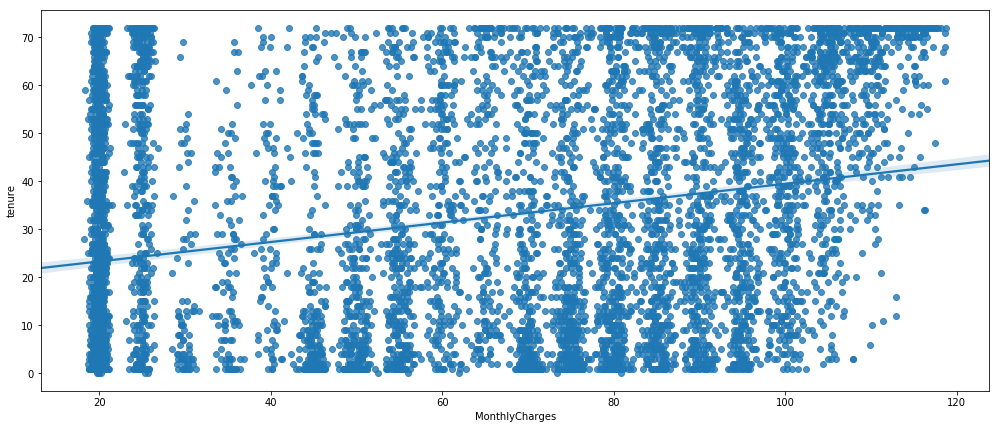

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
sn.regplot(x="MonthlyCharges", y="tenure", data=master_dataset)

### Target Variable Class Imbalance

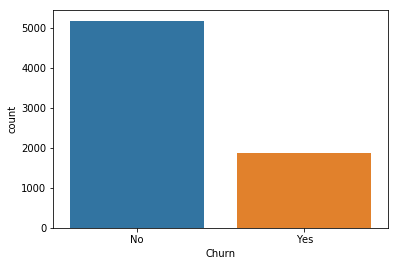

In [14]:
sn.countplot("Churn", data=master_dataset)

In [15]:
def fn_get_class_dist(values):
    all_cat_dist={}
    cat_cnts = values.value_counts()
    cat_per = cat_cnts*100/sum(cat_cnts)
    for cat_ in cat_cnts.index:
        cat_dist={}
        cat_dist["Count"]=cat_cnts[cat_]
        cat_dist["Percentage"]=cat_per[cat_]
        all_cat_dist[cat_]=cat_dist
    return all_cat_dist

In [16]:
fn_get_class_dist(master_dataset["Churn"])

{'No': {'Count': 5174, 'Percentage': 73.46301292063042},
 'Yes': {'Count': 1869, 'Percentage': 26.536987079369588}}

No class has 73% data where as yes class has 26% data. Theere is class imbalance in this dataset. Need to simulate by copying Yes class records.